In [13]:
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import operator

In [3]:
load_dotenv()

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [4]:
class FeedbackSchema(BaseModel):

    feedback: str = Field(description="Feedback of the essay")
    score: int = Field(description="Give a score 1 to 10",ge=0,lt=11)

In [5]:
structured_llm = llm.with_structured_output(FeedbackSchema)

In [6]:
essay = """The Power of Curiosity: Humanity’s Driving Force
Curiosity, that restless flicker of wonder, has shaped civilizations, birthed revolutions, and propelled humanity from the caves to the cosmos. It’s more than idle interest—it’s a compulsion to know, to explore, to unravel the “why” behind the “what.” In a world saturated with information, curiosity remains our compass, pointing toward deeper understanding.
🔍 Curiosity as an Evolutionary Advantage
From early humans crafting rudimentary tools to scientists decoding the human genome, curiosity has been central to survival and progress. Anthropologists argue that the urge to explore and question enabled Homo sapiens to adapt more effectively than other species. Our ancestors' desire to venture beyond familiar boundaries led to migrations, innovations, and the birth of language and culture.
🚀 Invention and Innovation
Every modern marvel, from electricity to artificial intelligence, began with a question no one had asked before. Think of Isaac Newton under his apple tree or Marie Curie probing the mysteries of radioactivity. Their breakthroughs were born not from instruction, but from insatiable curiosity. The most transformative inventors weren’t necessarily the smartest—they were the most inquisitive.
🌐 Curiosity in the Digital Age
Paradoxically, in today’s hyperconnected world, curiosity can be dulled by the instant gratification of search engines and algorithmic recommendations. But it still thrives—in citizen science projects, indie game development, backyard experiments, and late-night Wikipedia rabbit holes. Platforms like open-source repositories have democratized curiosity, allowing coders, tinkerers, and thinkers to collaborate and build knowledge in public.
🧠 The Science of Wonder
Neuroscience links curiosity to increased dopamine activity, reinforcing learning and memory. When we're curious, our brains reward us with pleasure—making it not just noble, but neurologically addictive. That’s why asking questions is a powerful pedagogical tool and why children, who ask hundreds of questions a day, are among the most effective learners.
🌱 Cultivating Curiosity
Curiosity isn’t reserved for the intellectually elite—it’s a mindset anyone can foster. Reading widely, embracing ambiguity, and resisting the temptation to settle for surface-level answers can reignite that fire. Even beginner gardeners or hobbyist programmers, when guided by curiosity, uncover insights that textbooks alone can’t teach.

Curiosity isn’t just a trait—it’s the soul of progress. Whether decoding black holes or puzzling over a garden pest, it’s the question behind the question that fuels true discovery. And maybe, just maybe, that’s the most human trait of all.
If you want me to spin this into something more poetic, debate-style, or tailored to a particular audience, I’d love to help!
"""

In [7]:
prompt = f"You are an intelligent AI. Give a detailed feedback and score 1 to 10 on the following essay:\n {essay}"
output = structured_llm.invoke(prompt)

In [11]:
print(output.feedback)
print(output.score)

This is a well-written and insightful essay on the power of curiosity. The essay effectively argues that curiosity is a driving force behind human progress and innovation. It provides compelling examples from history, science, and technology to support its claims. The structure is logical, and the writing is clear and engaging. The introduction and conclusion are particularly strong, framing curiosity as an essential human trait and the 'soul of progress.'

Here are some specific strengths:

*   **Strong Thesis:** The essay clearly establishes curiosity as a central driver of human advancement.
*   **Compelling Examples:** The essay uses a variety of examples, from historical figures like Newton and Curie to modern-day citizen science, to illustrate the power of curiosity.
*   **Well-Organized:** The essay is logically structured, with each paragraph focusing on a specific aspect of curiosity.
*   **Engaging Writing:** The writing is clear, concise, and engaging, making the essay a ple

In [25]:

class UPSCState(TypedDict):

    essay: str
    language_feedback: str
    clarity_feedback: str
    analysis_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int],operator.add]
    avg_score: float

In [26]:
def evaluate_lang(state:UPSCState):
    prompt = f"Give a detailed feedback and a score between 1 to 10 on the following essay:\n {state["essay"]}, on the basis of language"
    output = structured_llm.invoke(prompt)

    return {"language_feedback":output.feedback,"individual_scores":output.score}

In [27]:
def evaluate_clarity(state:UPSCState):
    prompt = f"Give a detailed feedback and a score between 1 to 10 on the following essay:\n {state["essay"]}, on the basis of clarity of depth"
    output = structured_llm.invoke(prompt)

    return {"clarity_feedback":output.feedback,"individual_scores":output.score}

In [28]:
def evaluate_clarity(state:UPSCState):
    prompt = f"Give a detailed feedback and a score between 1 to 10 on the following essay:\n {state["essay"]}, on the basis of depth of analysis"
    output = structured_llm.invoke(prompt)

    return {"analysis_feedback":output.feedback,"individual_scores":output.score}

In [29]:
def final_evaluation(state:UPSCState):
    prompt = f'''Generate a summary of give feedbacks, language_feedback: \n {state['language_feedback']}\n,clarity_feedback:\n {state['clarity_feedback']}, and \n analysis_feedback:\n {state["analysis_feedback"]}'''
    
    overall_feedback = llm.invoke(prompt)

    avg_score = sum(state["individual_scores"])/len(state["individual_scores"])

    return {"overall_feedback":overall_feedback,"avg_score":avg_score}

In [31]:
graph = StateGraph(UPSCState)

graph.add_node("lang_feedback",evaluate_lang)
graph.add_node("clarity_feedback",evaluate_clarity)
graph.add_node("analysis_feedback",evaluate_clarity)
graph.add_node("overall_feedback",final_evaluation)

graph.add_edge(START,"lang_feedback")
graph.add_edge(START,"clarity_feedback")
graph.add_edge(START,"analysis_feedback")

graph.add_edge("lang_feedback","overall_feedback")
graph.add_edge("clarity_feedback","overall_feedback")
graph.add_edge("analysis_feedback","overall_feedback")
graph.add_edge("lang_feedback",END)

workflow = graph.compile()

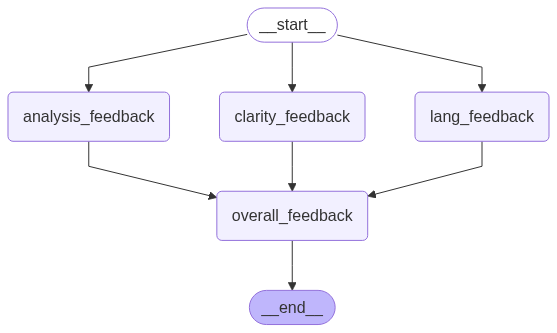

In [32]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())